## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

### Exercise 1.

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv('data_000637.txt',nrows=50000)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49995,1,1,2,3869200664,1103,4
49996,1,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,1,0,32,3869200664,1191,1


### Exercise 2.

In [9]:

df2=pd.read_csv('data_000637.txt',nrows=50000)
Unique_keys=np.unique(df2['ORBIT_CNT'])
bx_max=[df2['BX_COUNTER'][df2['ORBIT_CNT']==key].max() for key in Unique_keys] 
bx_orbit=np.array([Unique_keys,bx_max])
print(bx_orbit[:,0])
print(bx_orbit[:,1])
print(bx_orbit[:,-1])

[3869200167       3187]
[3869200168       3538]
[3869200664       1191]


### Exercise 3

In [11]:
df3=pd.read_csv('data_000637.txt',index_col=3,nrows=50000)
Unique_keys=np.unique(df3['BX_COUNTER'].keys())
bx=0
n=1310720
#df3['BX_COUNTER'][key]
for key in Unique_keys:
    lista=np.array(df3['BX_COUNTER'][key])
    bx+=max(lista)*25*10**(-9)+np.array(df3['TDC_MEAS'][key])[np.argmax(lista)]*5/6*10**(-9)


In [12]:
print('The data acquisition took',n*bx/50000,'s')


The data acquisition took 1.0579647747413325 s


### Exercise 4

In [13]:
df3=pd.read_csv('data_000637.txt',index_col=3,nrows=50000)

Time_abs=np.zeros(50000)
i_tot=0
prev_time=0
for key in Unique_keys:
    bx=np.array(df3['BX_COUNTER'][key])*25
    tdc=np.array(df3['TDC_MEAS'][key])*(5/6)
    for i in range(len(df3['BX_COUNTER'][key])):
        i_now=i_tot+i
        Time_abs[i_now]=bx[i]+tdc[i]+prev_time
    prev_time=max(Time_abs[i_tot:])
    i_tot+=i+1
Time_abs*=10**(-9)
df3['TIME_ABS']=Time_abs
df3

,HEAD,FPGA,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME_ABS
ORBIT_CNT,,,,,,
3869200167,1,0,123,2374,26,0.000059
3869200167,1,0,124,2374,27,0.000059
3869200167,1,0,63,2553,28,0.000064
3869200167,1,0,64,2558,19,0.000064
3869200167,1,0,64,2760,25,0.000069
...,...,...,...,...,...,...
3869200664,1,1,2,1103,4,0.040356
3869200664,1,1,4,1105,14,0.040356
3869200664,1,0,59,1191,17,0.040359


### Exercise 5

In [212]:
df3['HEAD']=np.random.randint(0,2,50000)
df3

,HEAD,FPGA,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME_ABS
ORBIT_CNT,,,,,,
3869200167,1,0,123,2374,26,0.000059
3869200167,1,0,124,2374,27,0.000059
3869200167,0,0,63,2553,28,0.000064
3869200167,1,0,64,2558,19,0.000064
3869200167,0,0,64,2760,25,0.000069
...,...,...,...,...,...,...
3869200664,0,1,2,1103,4,0.040356
3869200664,1,1,4,1105,14,0.040356
3869200664,1,0,59,1191,17,0.040359


### Exercise 6

In [213]:
df4=df3[df3['HEAD']==1]

In [214]:
df4

,HEAD,FPGA,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,TIME_ABS
ORBIT_CNT,,,,,,
3869200167,1,0,123,2374,26,0.000059
3869200167,1,0,124,2374,27,0.000059
3869200167,1,0,64,2558,19,0.000064
3869200167,1,0,61,2772,14,0.000069
3869200167,1,0,139,2776,0,0.000069
...,...,...,...,...,...,...
3869200664,1,0,50,1029,4,0.040355
3869200664,1,0,49,1036,8,0.040355
3869200664,1,0,47,1040,5,0.040355


### Exercise 7

139


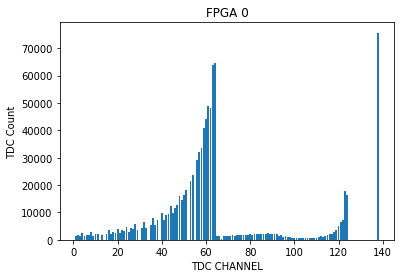

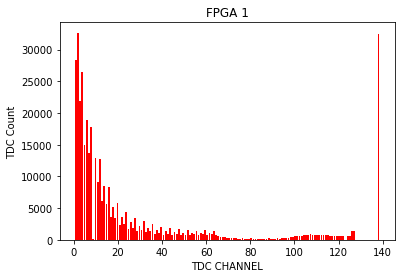

In [15]:
import matplotlib.pyplot as plt
df3=pd.read_csv('data_000637.txt',index_col=3)
tdc0=df3['TDC_CHANNEL'][df3['FPGA']==0]
print(max(tdc0))
tdc1=df3['TDC_CHANNEL'][df3['FPGA']==1]
hist0,edge0=np.histogram(tdc0,bins=(max(tdc0)-1))
hist1,edge1=np.histogram(tdc1,bins=max(tdc1))


plt.bar(edge0[:-1],hist0)
plt.xlabel('TDC CHANNEL')
plt.ylabel('TDC Count')
plt.title('FPGA 0')
plt.show()
plt.bar(edge1[:-1],hist1,color='r')
plt.xlabel('TDC CHANNEL')
plt.ylabel('TDC Count')
plt.title('FPGA 1')
plt.show()

### Exercise 8

In [16]:

df30=df3[df3['FPGA']==0]
tdc0=df30.groupby('TDC_CHANNEL').sum()
df31=df3[df3['FPGA']==1]
tdc1=df31.groupby('TDC_CHANNEL').sum()

In [17]:
sorted0=tdc0.sort_values('HEAD')[::-1]
print('The noisiest channels on FPGA0 are \n \n',sorted0[:3],'\n \n \n')
sorted1=tdc1.sort_values('HEAD')[::-1]
print('The noisiest channels on FPGA1 are \n \n',sorted1[:3],'\n \n \n')

The noisiest channels on FPGA0 are 
 
               HEAD  FPGA  BX_COUNTER  TDC_MEAS
TDC_CHANNEL                                   
139          75617     0   134482540         0
64           64581     0   115180305    941085
63           63724     0   113828187    924689 
 
 

The noisiest channels on FPGA1 are 
 
               HEAD   FPGA  BX_COUNTER  TDC_MEAS
TDC_CHANNEL                                    
2            32669  32669    58194220    475221
139          32442  32442    57995164         0
1            28438  28438    50854862    413328 
 
 



### Exercise 9 

In [18]:
print('There are',len(np.unique(df3['BX_COUNTER'].keys())), 'Unique orbits')

There are 11001 Unique orbits


In [19]:
df6=df3[df3['TDC_CHANNEL']==139]
print('There are',len(np.unique(df6['BX_COUNTER'].keys())), 'Unique orbits with at least one measurement from TDC Channel 139')

There are 10976 Unique orbits with at least one measurement from TDC Channel 139
